In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error

In [80]:
# read the data file
df = pd.read_csv("/data.csv")
# check for any missing values
na = sum(df['temp'].isna()) + sum(df['temp'].isna())
print("missing value count: {}".format(na))

missing value count: 0


In [81]:
# keeping a portion of data a side as the test data
test_df = df.iloc[120:]

# make sure the training phase does not see the above data
df = df.iloc[:120]

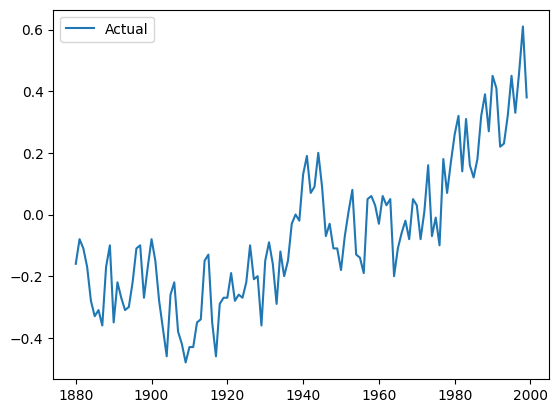

In [82]:
# look at the data by plotting it
plt.plot(df['year'], df['temp'], label='Actual')
plt.legend()
plt.show()

In [106]:
# difference the data series
lag = 1
data = np.array(df['temp'].diff(lag).dropna())

In [107]:
# normalize the data

# create the scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# fit the scaler to the data and transform the data
data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [108]:
# define a window size for the time series data
window_size = 11

# create the input/output pairs
X = [] # this will hold number of features equal to the window_size
y = [] # this will hold the dependent variable
for i in range(window_size, len(data_normalized)):
    X.append(data_normalized[i-window_size:i, 0])
    y.append(data_normalized[i, 0])

# convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [109]:
# split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print('train size: {}, test size: {}'.format(X_train.shape, X_test.shape))

train size: (86, 11), test size: (22, 11)


In [110]:
# define the LSTM model

model = Sequential()
model.add(LSTM(units=1024, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(units=1024, return_sequences=True))
model.add(LSTM(units=512, return_sequences=True))
model.add(LSTM(units=256, return_sequences=True))
model.add(LSTM(units=128, return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(units=1))

# compile the model. And for simlycity use all the default values for the hyper parameters
model.compile(optimizer='adam', loss='mse')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 1024)          4202496   
                                                                 
 lstm_1 (LSTM)               (None, 11, 1024)          8392704   
                                                                 
 lstm_2 (LSTM)               (None, 11, 512)           3147776   
                                                                 
 lstm_3 (LSTM)               (None, 11, 256)           787456    
                                                                 
 lstm_4 (LSTM)               (None, 11, 128)           197120    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 6

In [16]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [111]:
# fit the model, first try 100 epochs to train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/100
11/11 [==============================] - 12s 226ms/step - loss: 0.0980 - val_loss: 0.0651
Epoch 2/100
11/11 [==============================] - 0s 37ms/step - loss: 0.0568 - val_loss: 0.0581
Epoch 3/100
11/11 [==============================] - 0s 30ms/step - loss: 0.0452 - val_loss: 0.0575
Epoch 4/100
11/11 [==============================] - 0s 31ms/step - loss: 0.0439 - val_loss: 0.0581
Epoch 5/100
11/11 [==============================] - 0s 31ms/step - loss: 0.0453 - val_loss: 0.0601
Epoch 6/100
11/11 [==============================] - 0s 29ms/step - loss: 0.0479 - val_loss: 0.0612
Epoch 7/100
11/11 [==============================] - 0s 30ms/step - loss: 0.0440 - val_loss: 0.0596
Epoch 8/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0493 - val_loss: 0.0667
Epoch 9/100
11/11 [==============================] - 0s 30ms/step - loss: 0.0460 - val_loss: 0.0602
Epoch 10/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0432 - val_loss: 0.05

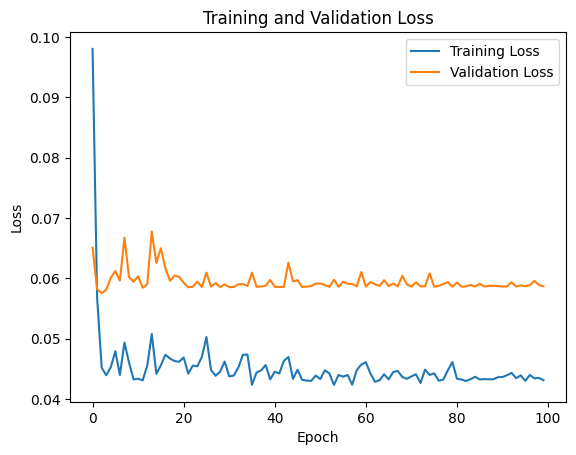

In [112]:
# plot the training and validation loss over each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [113]:
# Check the performance of the model with the validation data
now_predicting = model.predict(X_test)
predicted_transform = ( scaler.inverse_transform(now_predicting.reshape(-1, 1)).flatten() +
  df['temp'][-len(now_predicting)-lag:-lag].values )
len(predicted_transform)

1/1 [==============================] - 4s 4s/step


22

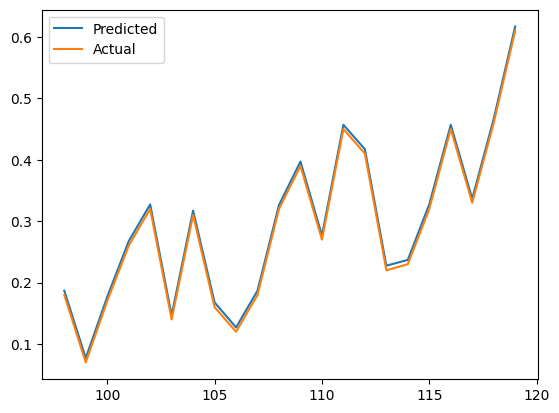

In [114]:
plt.plot(df.index[-len(predicted_transform):], predicted_transform, label='Predicted')
plt.plot(df.index[-len(predicted_transform):], df['temp'][-len(predicted_transform)-lag:-lag], label='Actual')
plt.legend()
plt.show()

In [21]:
# Check the performance of the model with the unseen data

# difference the reserved data series
test_data = np.array(test_df['temp'].diff(lag).dropna())

# noarmalize
test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 1))

# create the input/output pairs
test_X = [] # this will hold number of features equal to the window_size
test_y = [] # this will hold the dependent variable
for i in range(window_size, len(test_data_normalized)):
    test_X.append(test_data_normalized[i-window_size:i, 0])
    test_y.append(test_data_normalized[i, 0])
    
test_X = np.array(test_X)
test_y = np.array(test_y)

In [22]:
now_predicting = model.predict(test_X)
predicted_transform = ( scaler.inverse_transform(now_predicting.reshape(-1, 1)).flatten() +
  test_df['temp'][-len(now_predicting)-lag:-lag].values )
len(predicted_transform)

1/1 [==============================] - 0s 21ms/step


10

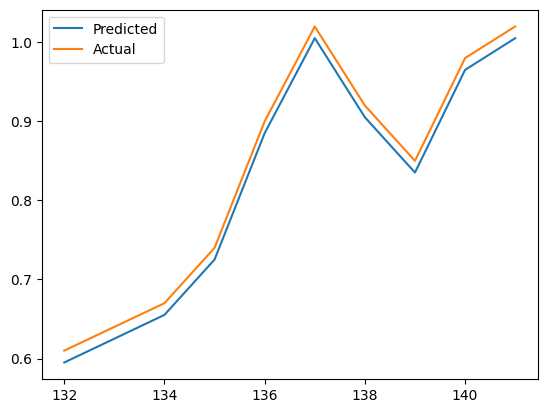

In [23]:
plt.plot(test_df.index[-len(predicted_transform):], predicted_transform, label='Predicted')
plt.plot(test_df.index[-len(predicted_transform):], test_df['temp'][-len(predicted_transform)-lag:-lag], label='Actual')
plt.legend()
plt.show()